In [1]:
pip install matplotlib


In [2]:
pip install seaborn

In [3]:
pip install pandas

In [4]:
pip install numpy

Cleansing

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
wolfsburg = pd.read_csv('/content/drive/MyDrive/DSA/wolfsburg.csv')

In [11]:
df = wolfsburg
df.head()

,day,interval,detid,flow,occ,error,city,speed
0,2016-09-19,0,K204D1A,0.0,0.000000,NaN,wolfsburg,NaN
1,2016-09-19,180,K204D1A,20.0,0.001833,NaN,wolfsburg,NaN
2,2016-09-19,360,K204D1A,60.0,0.029267,NaN,wolfsburg,NaN
3,2016-09-19,540,K204D1A,60.0,0.010733,NaN,wolfsburg,NaN
4,2016-09-19,720,K204D1A,20.0,0.001767,NaN,wolfsburg,NaN
...,...,...,...,...,...,...,...,...
95,2016-09-19,17100,K204D1A,40.0,0.003500,NaN,wolfsburg,NaN
96,2016-09-19,17280,K204D1A,20.0,0.003500,NaN,wolfsburg,NaN
97,2016-09-19,17460,K204D1A,20.0,0.002100,NaN,wolfsburg,NaN
98,2016-09-19,17640,K204D1A,20.0,0.003900,NaN,wolfsburg,NaN


In [13]:
df.shape

(893672, 8)

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings

In [20]:
# -------------------------------------------------------------------
# 1. LOAD DATA
# -------------------------------------------------------------------

print(df.head())

          day  interval    detid  flow       occ  error       city  speed
0  2016-09-19         0  K204D1A   0.0  0.000000    NaN  wolfsburg    NaN
1  2016-09-19       180  K204D1A  20.0  0.001833    NaN  wolfsburg    NaN
2  2016-09-19       360  K204D1A  60.0  0.029267    NaN  wolfsburg    NaN
3  2016-09-19       540  K204D1A  60.0  0.010733    NaN  wolfsburg    NaN
4  2016-09-19       720  K204D1A  20.0  0.001767    NaN  wolfsburg    NaN


In [21]:
# -------------------------------------------------------------------
# 2. CEK DATA YANG RUSAK
# -------------------------------------------------------------------

# 1. Cek data hilang
print("--- Pengecekan Data Hilang (NaN) ---")
print(df.isnull().sum())
print("\n")

# 2. Cek tipe data
print("--- Pengecekan Tipe Data (info) ---")
df.info()
print("\n")

# 3. Cek duplikat
print("--- Pengecekan Data Duplikat ---")
print(f"Jumlah baris duplikat: {df.duplicated().sum()}")
print("\n")

# 4. Cek statistik kolom angka (untuk outliers)
print("--- Pengecekan Statistik Angka (Describe) ---")
print(df.describe())
print("\n")

# 5. Cek konsistensi kolom kategori (ganti 'nama_kolom_kategori' dengan kolom Anda)
# Misalnya: print(df['kota'].value_counts())

print(df.count())

--- Pengecekan Data Hilang (NaN) ---
day              0
interval         0
detid            0
flow             0
occ             24
error       606772
city             0
speed       893672
dtype: int64


--- Pengecekan Tipe Data (info) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893672 entries, 0 to 893671
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   day       893672 non-null  object 
 1   interval  893672 non-null  int64  
 2   detid     893672 non-null  object 
 3   flow      893672 non-null  float64
 4   occ       893648 non-null  float64
 5   error     286900 non-null  float64
 6   city      893672 non-null  object 
 7   speed     0 non-null       float64
dtypes: float64(4), int64(1), object(3)
memory usage: 54.5+ MB


--- Pengecekan Data Duplikat ---
Jumlah baris duplikat: 0


--- Pengecekan Statistik Angka (Describe) ---
            interval           flow            occ     error  speed
count  8936

In [22]:
# -------------------------------------------------------------------
# CEK JUMLAH TANGGAL (BIAR GA KAYAK VADRID)
# -------------------------------------------------------------------

# Menghitung data unik, lalu mengurutkannya berdasarkan index (yaitu tanggal)
print(df['day'].value_counts().sort_index())

day
2016-09-19    63774
2016-09-20    63834
2016-09-21    63840
2016-09-22    63824
2016-09-23    63840
2016-09-24    63840
2016-09-25    63840
2016-09-26    63840
2016-09-27    63840
2016-09-28    63840
2016-09-29    63840
2016-09-30    63840
2016-10-01    63840
2016-10-02    63840
Name: count, dtype: int64


In [23]:
# -------------------------------------------------------------------
# 3. CEK JUMLAH BARIS YANG RUSAK (ERROR = 1; OCC = 0; FLOW < 0)
# -------------------------------------------------------------------


jumlah_baris = ((df['error'] == 1) | (df['occ'] == 0) | (df['flow'] < 0)).sum()
print(jumlah_baris)

375730


In [24]:
# -------------------------------------------------------------------
# 4. FIX KOLOM ERROR DAN FLOW LALU HAPUS KEDUANYA (DATA YANG GA PERLU)
# -------------------------------------------------------------------

# --- 1. Menghapus Baris Error (error == 1) ---
# Kita ingin mempertahankan baris yang error-nya BUKAN 1
# (Termasuk yang NaN atau 0)
jumlah_error_1 = (df['error'] == 1).sum()
print(f"Menghapus {jumlah_error_1} baris dengan error == 1...")
df = df[df['error'] != 1].copy()


# --- 2. Menghapus Baris Arus Tidak Logis (flow < 1) ---
# Filter ini juga akan otomatis menghapus baris yang flow-nya NaN
jumlah_flow_kecil = (df['flow'] < 1).sum()
print(f"Menghapus {jumlah_flow_kecil} baris dengan flow < 1...")
df = df[df['flow'] >= 1].copy()


# --- 3. Membuang Kolom 'error' ---
# Karena sudah tidak relevan, kita buang kolomnya
print("Membuang kolom 'error'...")
if 'error' in df.columns:
    df = df.drop(columns=['error'])
else:
    print("Kolom 'error' sudah tidak ada.")


# --- 4. Menghapus Sisa Baris NaN (Pembersih Akhir) ---
# Menghapus baris yang mungkin masih punya NaN di kolom penting
# (Ini akan menghapus baris 2575039 yang Anda temukan sebelumnya)
print(f"Jumlah baris sebelum pembersihan NaN akhir: {len(df)}")
df = df.dropna(subset=['interval', 'detid', 'flow', 'occ'])
print(f"Jumlah baris setelah pembersihan NaN akhir: {len(df)}")

Menghapus 286900 baris dengan error == 1...
Menghapus 84184 baris dengan flow < 1...
Membuang kolom 'error'...
Jumlah baris sebelum pembersihan NaN akhir: 522588
Jumlah baris setelah pembersihan NaN akhir: 522588


SARIMA

In [34]:
# Gabungkan tanggal & waktu
df['timestamp'] = pd.to_datetime(df['day']) + pd.to_timedelta(df['interval'], unit='s')

# Filter Sensor Terbaik
target_detector = df['detid'].value_counts().idxmax()
print(f"Menggunakan Sensor: {target_detector}")
df = df[df['detid'] == target_detector].copy()

# Set Index
df.set_index('timestamp', inplace=True)
df.sort_index(inplace=True)

Menggunakan Sensor: K205D1A


In [35]:
# 2. RESAMPLING & FITUR TAMBAHAN
# Ubah ke per Jam (Hourly)
ts_hourly = df['flow'].resample('H').mean().interpolate(method='linear')

# --- TRIK KHUSUS: DETEKSI WEEKEND ---
# Kita buat data bantuan (Exogenous) untuk memberitahu model mana Sabtu/Minggu
# 0 = Hari Kerja, 1 = Akhir Pekan (Sabtu/Minggu)
exog_data = pd.DataFrame(index=ts_hourly.index)
exog_data['is_weekend'] = (exog_data.index.dayofweek >= 5).astype(int)

In [36]:
# 3. PEMBAGIAN DATA (TRAIN vs TEST)
# Kita ambil 3 hari terakhir untuk tes, sisanya untuk training
test_days = 3
test_steps = test_days * 24

# Data Training (Mulai tanggal 19 sampai sebelum 3 hari terakhir)
train_data = ts_hourly[:-test_steps]
train_exog = exog_data[:-test_steps]

# Data Test (3 Hari Terakhir)
test_data = ts_hourly[-test_steps:]
test_exog = exog_data[-test_steps:]

print(f"Data Training Mulai : {train_data.index.min()}")
print(f"Data Training Selesai: {train_data.index.max()}")
print(f"Jumlah Jam Training : {len(train_data)} jam")

Data Training Mulai : 2016-09-19 00:00:00
Data Training Selesai: 2016-09-29 23:00:00
Jumlah Jam Training : 264 jam


In [37]:
# 4. TRAINING MODEL SARIMA (DENGAN FITUR WEEKEND)
print("\nSedang melatih model (tunggu sebentar)...")
# Order=(1,0,1) dan Seasonal=(1,1,1,24) adalah kombinasi umum yang stabil
model = SARIMAX(train_data,
                exog=train_exog,  # Masukkan fitur weekend di sini
                order=(1, 0, 1),
                seasonal_order=(1, 1, 1, 24),
                enforce_stationarity=False,
                enforce_invertibility=False)

model_fit = model.fit(disp=False)


Sedang melatih model (tunggu sebentar)...


In [38]:
# 5. PREDIKSI
# Kita butuh data exog (info weekend) untuk masa depan agar prediksi akurat
forecast = model_fit.get_forecast(steps=len(test_data), exog=test_exog)
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Hitung Error
rmse = np.sqrt(mean_squared_error(test_data, predicted_mean))
print(f"Selesai! RMSE: {rmse:.2f}")

Selesai! RMSE: 134.23


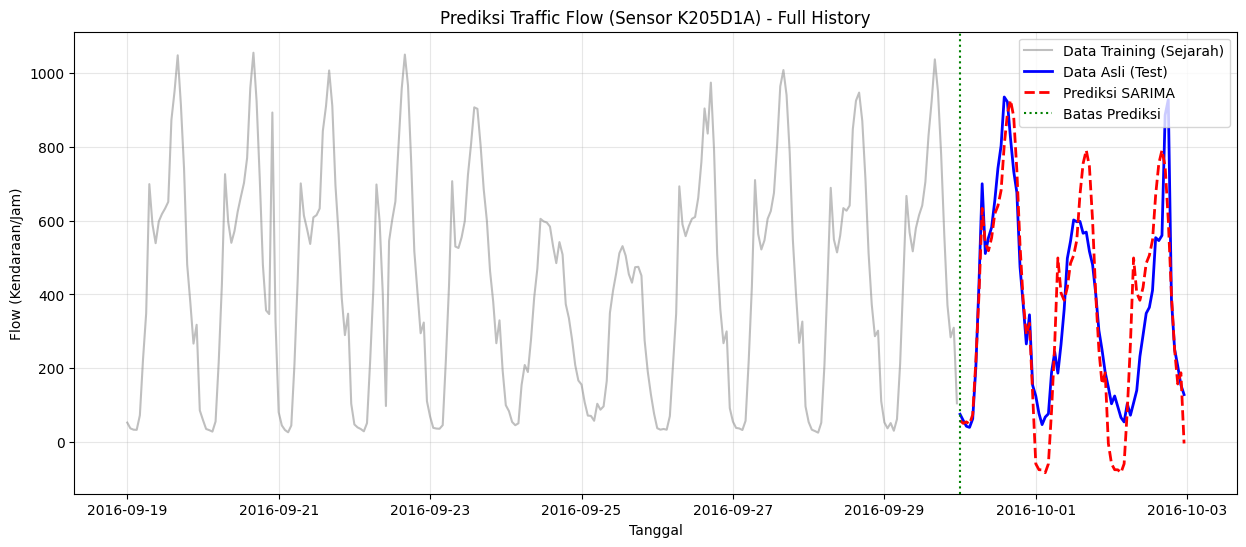

In [39]:
# 6. VISUALISASI LENGKAP
plt.figure(figsize=(15, 6))

# Plot Data Training (Full dari tanggal 19)
plt.plot(train_data.index, train_data, label='Data Training (Sejarah)', color='gray', alpha=0.5)

# Plot Data Asli (Test)
plt.plot(test_data.index, test_data, label='Data Asli (Test)', color='blue', linewidth=2)

# Plot Hasil Prediksi
plt.plot(predicted_mean.index, predicted_mean, label='Prediksi SARIMA', color='red', linestyle='--', linewidth=2)

# Garis pembatas Training / Test
plt.axvline(x=test_data.index[0], color='green', linestyle=':', label='Batas Prediksi')

plt.title(f'Prediksi Traffic Flow (Sensor {target_detector}) - Full History')
plt.xlabel('Tanggal')
plt.ylabel('Flow (Kendaraan/Jam)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ... (setelah perhitungan forecast) ...

rmse = np.sqrt(mean_squared_error(test_data, predicted_mean))
mae = mean_absolute_error(test_data, predicted_mean)

print(f"Performa Model:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")

Performa Model:
RMSE: 134.23
MAE : 104.32


In [41]:
print(f"Rata-rata Data Asli: {test_data.mean():.2f}")

Rata-rata Data Asli: 363.74
